#  XPCS   Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [ ]:
hdr = db[{{ uid }}]

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from ipywidgets import interact

In [3]:
cd /home/yuzhang/chx-pipelines/Develops/

/home/yuzhang/chx-pipelines/Develops


In [ ]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

In [6]:
%run develop.py
%run two_time.py

In [5]:
%matplotlib notebook
#%matplotlib inline

# Users put 
* uid for Bluesky Scan
* filename for acquiring data directly by EigerSofteare

In [7]:
BlueScan = True
DirectAcq = False
detector = 'eiger_4M_cam_img_image_lightfield'  #for 4M

# Users put uid here

In [8]:
if BlueScan:
    uid = '54614d43'
    #uid = '95782687'
    uid = '95782687'
    uid= 'ff9f20c0'
    uid='71720966'
    uid='1663d34a'
    uid = 'f505e052-3baa-47d4-bdc4-61c2eb1bcc7a'  #sid= 551, 1%PEG, 
    uid='ee6975a1-9161'   #1% wt PEG
    uid = 'ffe9d518'  # 10 mTorr 1sec/frame
else:
    uid = '/XF11ID/data/2015/11/23/d01ab510-3cf3-4719-bee3_795_master.h5' 

### Get data

In [11]:
if BlueScan:
    hdr = db[uid]
    ev, = get_events(  hdr, [detector] )
    imgs = ev['data'][detector]
else:    
    imgs =  Images(uid)
print (imgs)
Nimg=len(imgs)

hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5
<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


### Get data path

In [12]:
if BlueScan:
    from datetime import datetime
    dt = datetime.fromtimestamp(hdr['start'].time)
    path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
else:
    path ='/XF11ID/analysis/2015/11/23/' 
path

'/XF11ID/analysis/2015/11/8/'

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [13]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'framerate': 0.99998998651994853,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [14]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4812.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## load a mask
#### load the mask saved in the mask_pipeline

In [15]:
mask = np.load( path +  str(uid)+ "_mask.npy")


### Reverse the mask in y-direction due to the coordination difference between python and Eiger software 

In [16]:
maskr = mask[::-1,:]

## Plot the mask

<IPython.core.display.Javascript object>


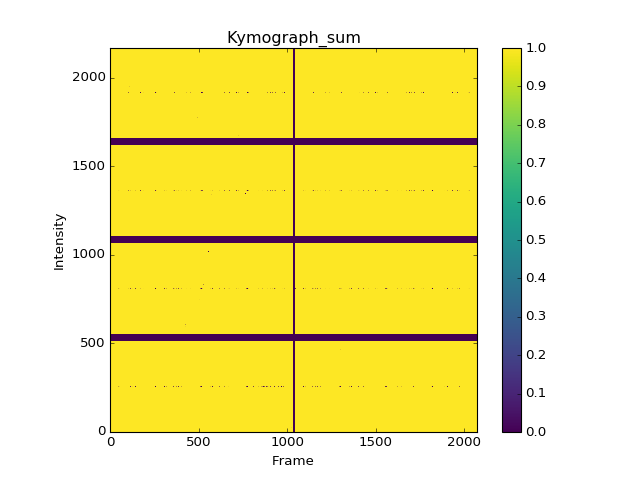

In [17]:
fig, ax = plt.subplots()
im=ax.imshow(maskr, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

In [18]:
def view_image(i):    
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e1) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    

In [19]:
#interact(view_image, i=(0, Nimg-1))

## Movie

In [20]:
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        im=ax.imshow(imgs[i]*mask,  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.01, vmax=10 ) )
        ax.set_title("images_%s"%i)
        
        time.sleep( sleeps )
        plt.draw()
    #fig.colorbar(im)
        
#view_image(.2, 0, 2)

### hey, let's see if any images are bad!

#### load the image intensity (kymograph) saved in the mask_pipeline

In [21]:
kymo_sum = np.load( path +  str(uid)+"_kymo_sum.npy" ) 

In [22]:
bad_frames = np.where( kymo_sum > 1e5)[0]
bad_frames

array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784])

<IPython.core.display.Javascript object>


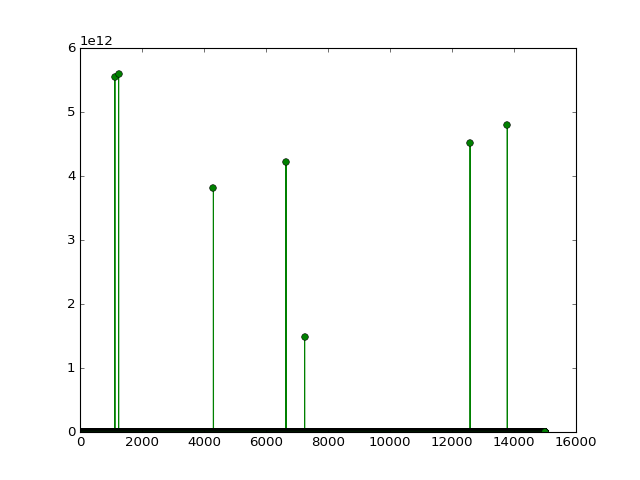

In [23]:
fig, axes = plt.subplots(  )
axes.plot( kymo_sum, '-go'  ) 
ax.set_ylabel('Intensity')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_sum') 
plt.show()

### Get the Averaged Image Data

#### load the average intensity saved in the mask_pipeline

In [24]:
avg_img = np.load( path + str(uid)+"_avg_img.npy" )
avg_imgm =  avg_img * mask

### Reverse the image in y-direction due to the coordination difference between python and Eiger software 

In [25]:
avg_imgr  = avg_img[::-1,:] 
avg_imgmr  = avg_imgm[::-1,:] 

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


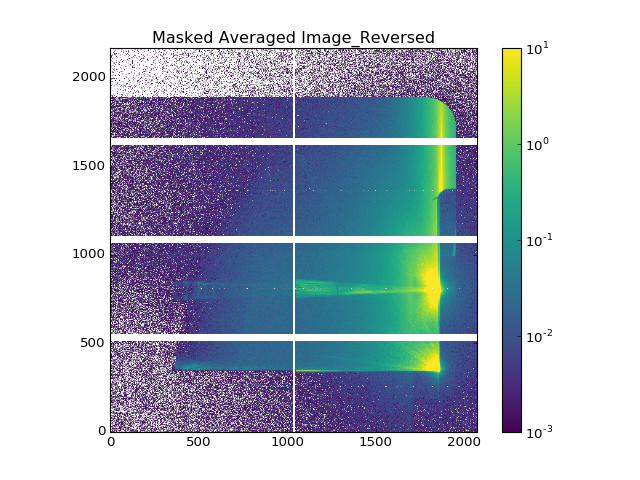

In [26]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgmr, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)
plt.show()

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)


## Get the approximate center and see the statistic to make sure 

In [27]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4810        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## GiSAXS get q-map (qz and qr)

### Users put incident-Beam and Reflection_Beam Centers here!!!

In [30]:
inc_x0 = 1871
inc_y0 = 339
refl_x0 = 1871
refl_y0 = 811      #1670
Lsd= 4.81
lamda= lambda_  #12.4/9

In [29]:
# inc_x0 = 1000
# inc_y0 = 339
# refl_x0 = 1000
# refl_y0 = 811      #1670
# Lsd= 4.81
# lamda= lambda_  #12.4/9

In [31]:
lamda

1.3776

In [32]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


In [33]:
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lamda, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


In [34]:
#show_qz(qz)

In [35]:
#show_qr(qr)

In [36]:
#show_alphaf(alphaf)

<IPython.core.display.Javascript object>


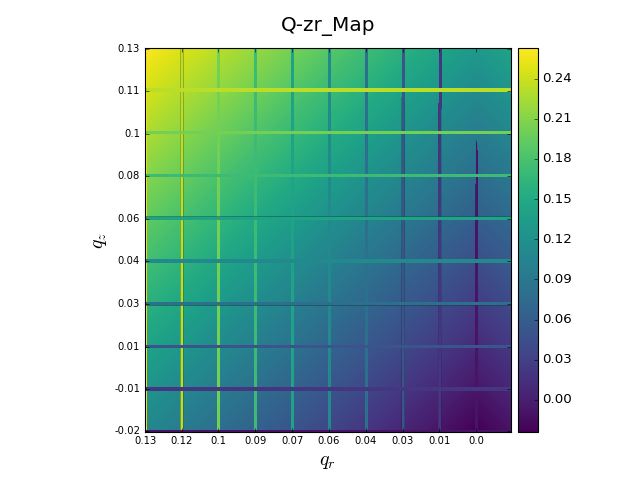

In [347]:
ticks = show_qzr_map(  qr, qz, inc_x0, data = None, Nzline=10, Nrline= 10   )

<IPython.core.display.Javascript object>


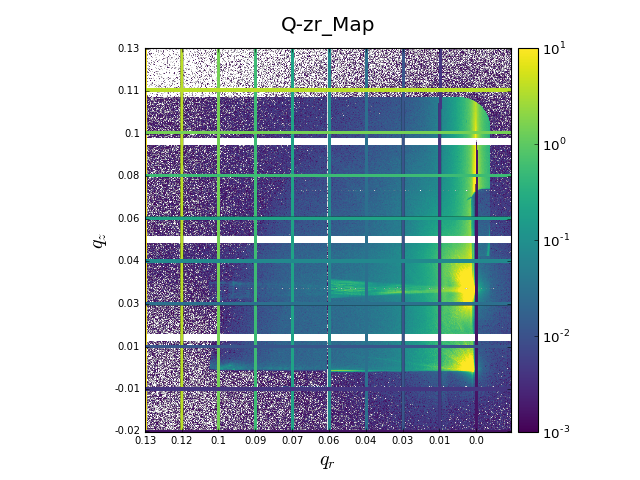

In [348]:
ticks = show_qzr_map(  qr,qz, inc_x0, data = avg_imgmr, Nzline=10,  Nrline=10   )

# Get q||-intensity

<IPython.core.display.Javascript object>


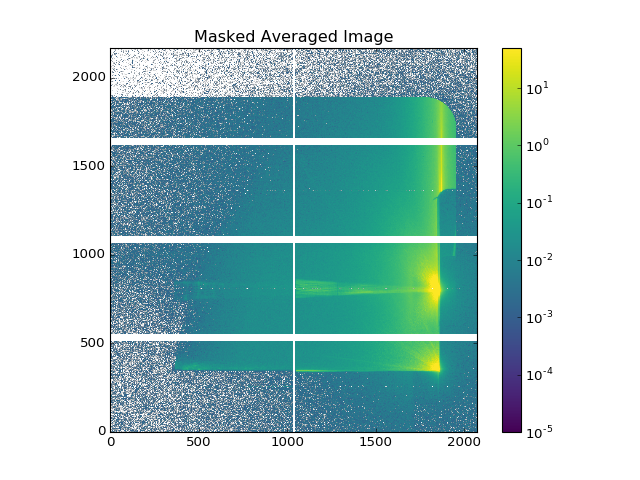

In [39]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgr, cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=.5e2 ) )
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## Users put cuts here!!!

In [40]:
vert_rect = ( ( 850, 0, 980- 850, 1600-0) , ( 570, 0, 700- 570, 1600-0) )    #(y,x, hight, wdith)

In [95]:
new_mask = np.ones_like( avg_imgr)
new_mask[ :, 1020:1045] =0

In [351]:
#to make two-qz, from 0.018 to 0.046, width as 0.008, 

qz_width = 0.008
qz_start = 0.018 + qz_width/2
qz_end = 0.046  -  qz_width/2
qz_num= 2


#to make one-qr, from 0.02 to 0.1, and the width is 0.1-0.012
qr_width =  0.1-0.02
qr_start =    0.02 + qr_width  /2
qr_end =  0.01 -  qr_width  /2
qr_num = 1
 
Qr = [qr_start , qr_end, qr_width, qr_num]
Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

The qr_edge is:  [ 0.02  0.1 ]
The qr_center is:  [ 0.06]
The qz_edge is:  [ 0.018  0.026  0.038  0.046]
The qz_center is:  [ 0.022  0.042]


-c:19: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


<IPython.core.display.Javascript object>


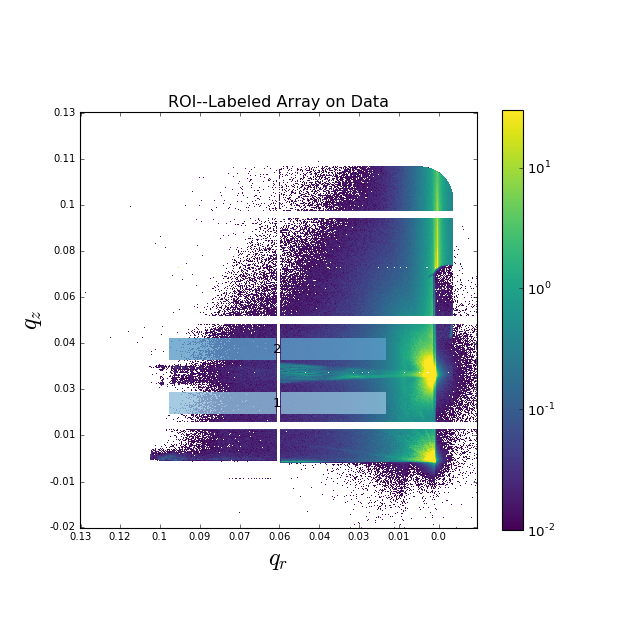

<IPython.core.display.Javascript object>


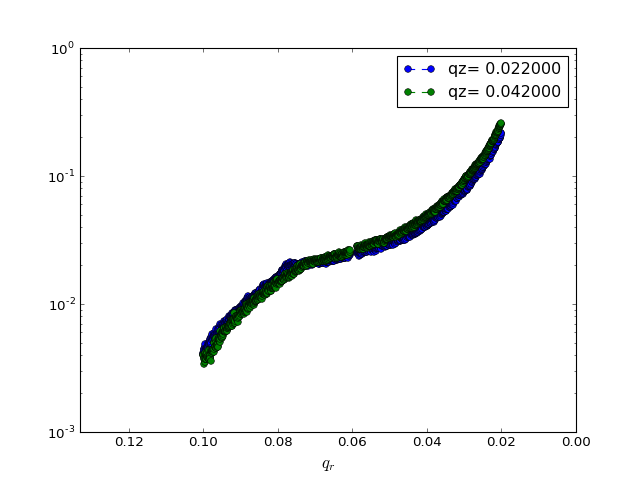

0 0.022
0.022 [ 0.018  0.026]
[0 1]
1 0.042
0.042 [ 0.038  0.046]
[0 1]


-c:31: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


In [352]:
get_1d_qr( qr, qz, inc_x0, avg_imgr, Qr,Qz, new_mask,  True, zticks, zticks_label, rticks, rticks_label, .8)

In [333]:
qr_edge, qr_center = get_qedge(qr_start , qr_end, qr_width, qr_num )
qz_edge, qz_center = get_qedge( qz_start,   qz_end,  qz_width , qz_num )

print ('The qr_edge is:  %s\nThe qr_center is:  %s'%(qr_edge, qr_center))
print ('The qz_edge is:  %s\nThe qz_center is:  %s'%(qz_edge, qz_center))
label_array_qz = get_qmap_label( qz, qz_edge)
label_array_qr = get_qmap_label( qr, qr_edge)
label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )


labels_qzr, indices_qzr = roi.extract_label_indices( label_array_qzr  )
labels_qz, indices_qz = roi.extract_label_indices( label_array_qz  )
labels_qr, indices_qr = roi.extract_label_indices( label_array_qr  )

num_qz = len(np.unique( labels_qz ))
num_qr = len(np.unique( labels_qr ))
num_qzr = len(np.unique( labels_qzr ))

The qr_edge is:  [ 0.02  0.1 ]
The qr_center is:  [ 0.06]
The qz_edge is:  [ 0.015  0.023  0.072  0.08 ]
The qz_center is:  [ 0.019  0.076]


In [334]:
np.where( label_array_qzr  ==1)

(array([550, 550, 550, ..., 662, 662, 662]),
 array([ 465,  466,  467, ..., 1587, 1588, 1589]))

In [335]:
label_array_qzr[ np.where( label_array_qzr  ==1)  ]

array([1, 1, 1, ..., 1, 1, 1])

In [336]:
qz_center

array([ 0.019,  0.076])

In [337]:
qz_edge

array([ 0.015,  0.023,  0.072,  0.08 ])

In [338]:
%run develop.py

In [339]:
#qr

In [340]:
def get_1d_qr( qr, qz, inc_x0, data, Qr,Qz, mask=None, show_roi=True,
             zticks=None, zticks_label=None, rticks=None, rticks_label=None,alpha=0.3):
    
    qr_start , qr_end, qr_width, qr_num =Qr
    qz_start,   qz_end,  qz_width , qz_num =Qz
    qr_edge, qr_center = get_qedge(qr_start , qr_end, qr_width, qr_num )    
    qz_edge, qz_center = get_qedge( qz_start,   qz_end,  qz_width , qz_num )

    
    print ('The qr_edge is:  %s\nThe qr_center is:  %s'%(qr_edge, qr_center))
    print ('The qz_edge is:  %s\nThe qz_center is:  %s'%(qz_edge, qz_center))    
    label_array_qr = get_qmap_label( qr, qr_edge)

    if show_roi:
        label_array_qz0 = get_qmap_label( qz , qz_edge)
        label_array_qzr0,qzc0,qrc0 = get_qzrmap(label_array_qz0, label_array_qr,qz_center, qr_center  )
    
        
        if mask is not None:label_array_qzr0 *= mask
        #data_ = data*label_array_qzr0   
        
        show_qzr_roi( data,label_array_qzr0, inc_x0, zticks, zticks_label, rticks, rticks_label, alpha)

    fig, ax = plt.subplots()
    for i,qzc_ in enumerate(qz_center):
        print (i,qzc_)
        label_array_qz = get_qmap_label( qz, qz_edge[i*2:2*i+2])
        print (qzc_, qz_edge[i*2:2*i+2])
        label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )
        print (np.unique(label_array_qzr ))    
        if mask is not None:label_array_qzr *=   mask
        roi_pixel_num = np.sum( label_array_qzr, axis=0)
        qr_ = qr  *label_array_qzr
        data_ = data*label_array_qzr    
        qr_ave = np.sum( qr_, axis=0)/roi_pixel_num
        data_ave = np.sum( data_, axis=0)/roi_pixel_num     
        ax.plot( qr_ave, data_ave,  '--o', label= 'qz= %f'%qzc_)
        
        
    ax.set_xlabel( r'$q_r$', fontsize=15)
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_xlim(   qr.max(),qr.min()  )
    ax.legend(loc='best')

    
    

In [341]:
print (np.unique(label_array_qzr ))    

[0 1 2]


In [342]:
qzc_, qz_edge[i*2:2*i+2]

(0.036000000000000004, array([ 0.072,  0.08 ]))

In [343]:
mask

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint32)

In [344]:
qz_edge

array([ 0.015,  0.023,  0.072,  0.08 ])

<IPython.core.display.Javascript object>


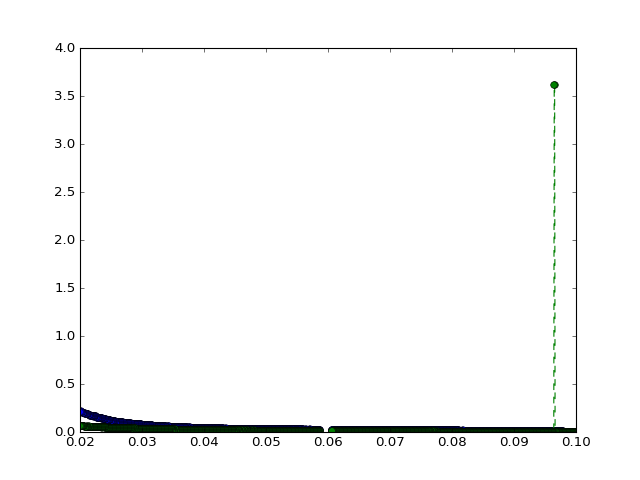

0 0.019
0.019 [ 0.015  0.023]
7461.09387087
1 0.076
0.076 [ 0.072  0.08 ]
7460.93723701


-c:8: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


In [345]:
    fig, ax = plt.subplots()
    for i,qzc_ in enumerate( qz_center ):
        print (i,qzc_)
        label_array_qz = get_qmap_label( qz, qz_edge[i*2:2*i+2])
        print (qzc_, qz_edge[i*2:2*i+2])
        label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )
        #print (np.unique(label_array_qzr ))    
        if mask is not None:label_array_qzr *=  new_mask
        roi_pixel_num = np.sum( label_array_qzr, axis=0)
        qr_ = qr  *label_array_qzr
        data = avg_imgmr
        data_ = data*label_array_qzr    
        qr_ave = np.sum( qr_, axis=0)/roi_pixel_num
        print (np.sum( qr_, axis=0).sum())
        data_ave = np.sum( data_, axis=0)/roi_pixel_num     
        ax.plot( qr_ave, data_ave,  '--o', label= 'qz= %f'%qzc_)

<IPython.core.display.Javascript object>


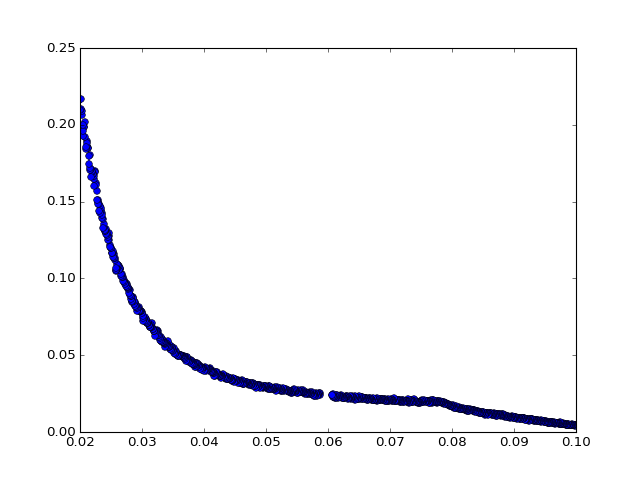

0 0.036
0.036 [ 0.015  0.023]
[0 1]


-c:8: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


In [326]:
    fig, ax = plt.subplots()
    for i,qzc_ in enumerate([qz_center[1]]):
        print (i,qzc_)
        label_array_qz = get_qmap_label( qz, qz_edge[i*2:2*i+2])
        print (qzc_, qz_edge[i*2:2*i+2])
        label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )
        print (np.unique(label_array_qzr ))    
        if mask is not None:label_array_qzr *=  new_mask
        roi_pixel_num = np.sum( label_array_qzr, axis=0)
        qr_ = qr  *label_array_qzr
        data = avg_imgmr
        data_ = data*label_array_qzr    
        qr_ave = np.sum( qr_, axis=0)/roi_pixel_num
        data_ave = np.sum( data_, axis=0)/roi_pixel_num     
        ax.plot( qr_ave, data_ave,  '--o', label= 'qz= %f'%qzc_)

In [313]:
s = np.sum( label_array_qzr, axis=0)

In [314]:
data_ = data*label_array_qzr   
data_ave = np.sum( data_, axis=0)

In [315]:
data_ave

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [316]:
data_ave.shape

(2070,)

In [317]:
data_ave/s

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [318]:
m=data_ave/s

<IPython.core.display.Javascript object>


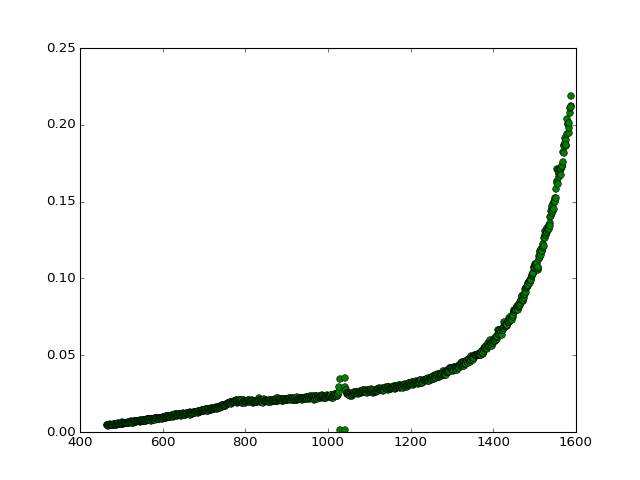

In [320]:
fig, ax = plt.subplots()
ax.plot(m,'go')

<IPython.core.display.Javascript object>


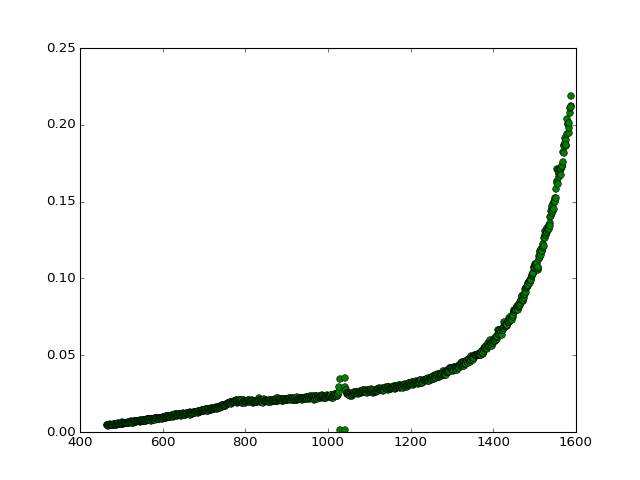

In [308]:
fig, ax = plt.subplots()
ax.plot(data_ave/s,'go')

In [284]:
np.unique( label_array_qzr )

array([0, 1])

In [285]:
np.where( label_array_qzr ==1)

(array([551, 551, 551, ..., 662, 662, 662]),
 array([ 465,  466,  467, ..., 1587, 1588, 1589]))

In [286]:
label_array_qzr.shape

(2167, 2070)

In [287]:
label_array_qzr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<IPython.core.display.Javascript object>


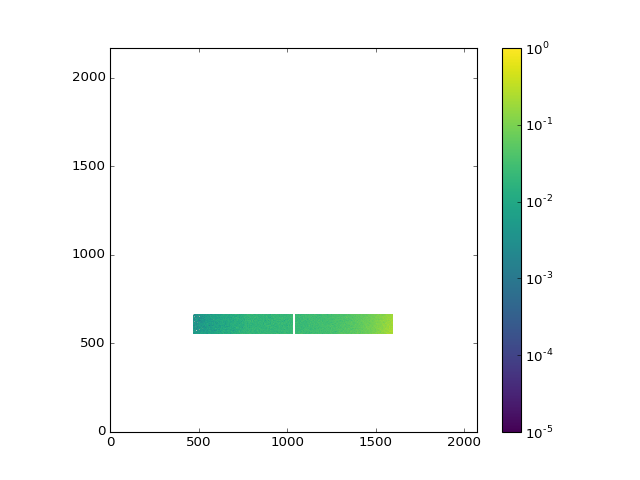

In [297]:
fig, ax = plt.subplots()
im = ax.imshow( data_ , cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=1) )
 
fig.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


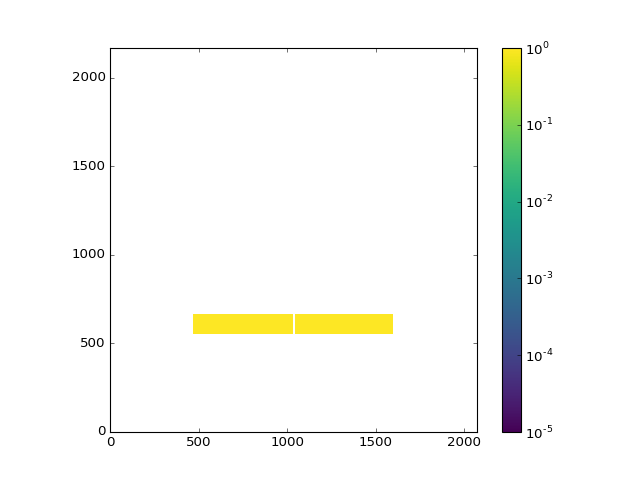

In [288]:
fig, ax = plt.subplots()
im = ax.imshow( label_array_qzr , cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=1) )
 
fig.colorbar(im)
plt.show()

In [242]:
Qz

[0.019, 0.036000000000000004, 0.008, 2]

The qr_edge is:  [ 0.02  0.1 ]
The qr_center is:  [ 0.06]
The qz_edge is:  [ 0.015  0.023  0.072  0.08 ]
The qz_center is:  [ 0.019  0.076]


-c:19: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


<IPython.core.display.Javascript object>


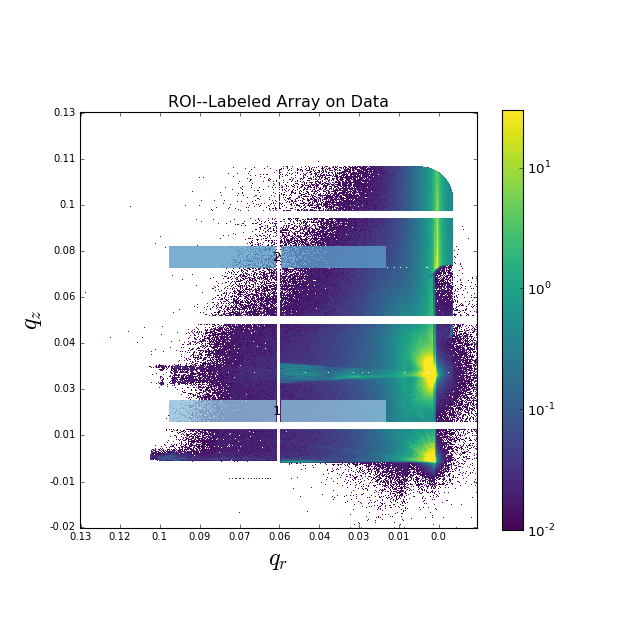

<IPython.core.display.Javascript object>


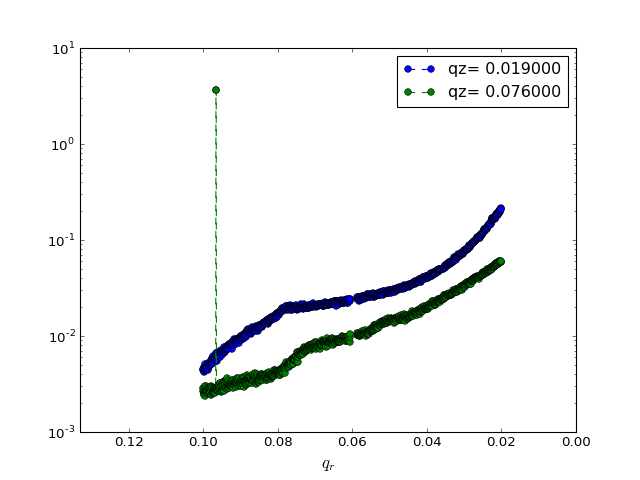

0 0.019
0.019 [ 0.015  0.023]
[0 1]
1 0.076
0.076 [ 0.072  0.08 ]
[0 1]


-c:31: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


In [346]:
get_1d_qr( qr, qz, inc_x0, avg_imgr, Qr,Qz, new_mask,  True,zticks, zticks_label, rticks, rticks_label, .8)

In [182]:
qr_edge, qr_center

(array([ 0.014,  0.1  ]), array([ 0.057]))

In [ ]:
        roi_pixel_num = np.sum( V_K_label_array_i, axis=0)
        qr_ = qr  *V_K_label_array_i
        data_ = data*V_K_label_array_i  
    
        qr_ave = np.sum( qr_, axis=0)/roi_pixel_num
        data_ave = np.sum( data_, axis=0)/roi_pixel_num  

In [116]:
labels_qzr.shape

(362730,)

In [117]:
label_array_qzr 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<IPython.core.display.Javascript object>


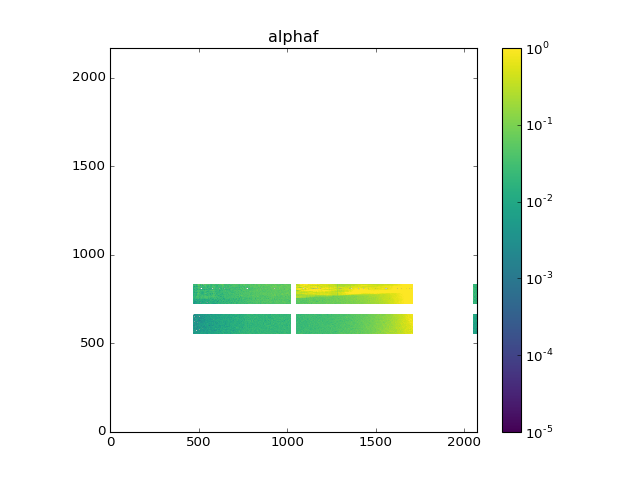

In [157]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow( label_array_qzr * avg_imgr*new_mask,  cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=1 ) )
#im=ax.imshow(  avg_imgr ,  cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=1 ) , alpha=.8)


fig.colorbar(im)
ax.set_title( 'alphaf')
plt.show()

In [228]:
vert_rect

((850, 0, 130, 1600), (570, 0, 130, 1600))

In [235]:
qz[570,100]

0.016427899452567268

In [236]:
qz[850,100]

0.036339878979782914

<IPython.core.display.Javascript object>


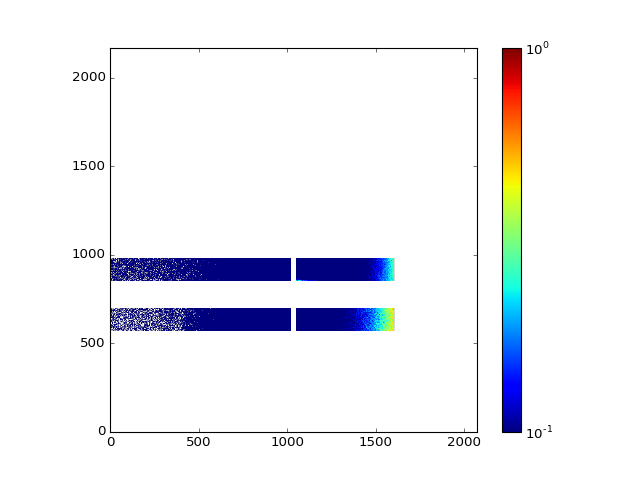

<IPython.core.display.Javascript object>


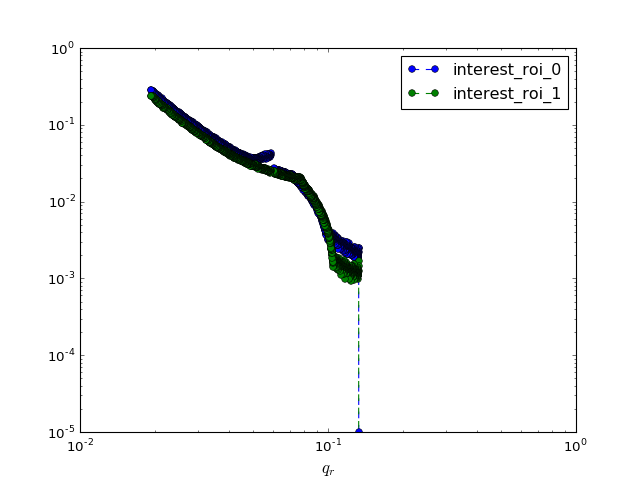

0 (850, 0, 130, 1600)
1 (570, 0, 130, 1600)


In [42]:
get_qr_intensity( qr, avg_imgr, vert_rect, mask=new_mask, show_roi=True)

## User gives the interested Qz,Qr here!!! 
To define the ROI
* user can use pixel value
* user also can use qz,qr value

In [ ]:
qz_start = qz[670,0]
qz_end = qz[950,0]
qz_num= 2

qr_start =  qr[600,1700]
qr_end = qr[600,0]
qr_num = 15

In [43]:
qz_start = qz[670,0]
qz_end = qz[950,0]
qz_num= 2

qr_start =  0.01
qr_end = 0.1
qr_num = 15

In [44]:
qz_start

0.023539450951822419

## Create label array (Qz, Qr, Qzr boxes)

In [45]:
qr_edge, qr_center = get_qedge(qr_start , qr_end, ( qr_end- qr_start)/qr_num, qr_num )
qz_edge, qz_center = get_qedge( qz_start,   qz_end,   (qz_end - qz_start)/(qz_num -0) , qz_num )

label_array_qz = get_qmap_label( qz, qz_edge)
label_array_qr = get_qmap_label( qr, qr_edge)
label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )

labels_qzr, indices_qzr = roi.extract_label_indices( label_array_qzr  )
labels_qz, indices_qz = roi.extract_label_indices( label_array_qz  )
labels_qr, indices_qr = roi.extract_label_indices( label_array_qr  )

num_qz = len(np.unique( labels_qz ))
num_qr = len(np.unique( labels_qr ))
num_qzr = len(np.unique( labels_qzr ))

In [47]:
label_array_qzr.shape

(2167, 2070)

In [48]:
qzc

array([ 0.02353945,  0.04345093,  0.02353945,  0.04345093,  0.02353945,
        0.04345093,  0.02353945,  0.04345093,  0.02353945,  0.04345093,
        0.02353945,  0.04345093,  0.02353945,  0.04345093,  0.02353945,
        0.04345093,  0.02353945,  0.04345093,  0.02353945,  0.04345093,
        0.02353945,  0.04345093,  0.02353945,  0.04345093,  0.02353945,
        0.04345093,  0.02353945,  0.04345093,  0.02353945,  0.04345093])

In [49]:
labels_qzr

array([15, 15, 15, ..., 17, 17, 17])

In [50]:
indices_qzr

array([1244493, 1244494, 1244495, ..., 2113467, 2113468, 2113469])

In [ ]:
num_qz,num_qr,num_qzr

## Extract the labeled array

In [ ]:
boxes = label_array_qzr 
box_maskr = boxes*maskr


In [ ]:
qind, pixelist = roi.extract_label_indices(   box_maskr  )
noqs = len( np.unique(qind) )
nopr = np.bincount(qind, minlength=(noqs+1))[1:]

## Number of pixels in each q ring

In [ ]:
nopr

## plot average image with interested Q-regions (boxes)

In [ ]:
%run develop.py

In [ ]:
show_qzr_roi( avg_imgr, box_maskr, inc_x0, zticks, zticks_label, rticks, rticks_label)

##  Kymograph(waterfall plot) of the max-intensity ring

In [ ]:
imgs_ =imgs
imgsr = Reverse_Coordinate(imgs_, maskr)    

In [ ]:
t0 = time.time()
data_pixel =   Get_Pixel_Array( imgsr, pixelist).get_data()
run_time(t0)

### users put the number of ring with max intensity here

In [ ]:
max_inten_ring =2

In [ ]:
pixelist_qi =  np.where( qind == max_inten_ring )[0]         
data_pixel_qi = data_pixel[:,pixelist_qi] 

In [ ]:
data_pixel_qi.shape

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(data_pixel_qi.T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(1.)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_4000-6000')

im = ax.imshow(data_pixel_qi[4000:6000,:].T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(.1)
plt.show()

## TIme~Mean intensities for each ring

In [ ]:
mean_inten = get_mean_intensity( data_pixel, qind)

In [ ]:
times = np.arange(  mean_inten[1].shape[0]   )  #*timeperframe  # get the time for each frame

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Mean intensity of each box")
for i in range(  num_qzr  ):
    ax.plot(times, mean_inten[i+1], '--o', label="Box "+str(i+1))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean Intensity")
    ax.set_ylim(0, 2.5)
    
ax.legend( loc='best', fontsize = 6) 
plt.show()

##  Mean intensities for each ring

In [ ]:
mask_data =   np.arange( len(data_pixel))  
mask_data_ = np.delete( mask_data, bad_frames)

In [ ]:
#mask_data_

In [ ]:
#mean_inten[1][:1000].mean()

In [ ]:
K_mean = np.array( [mean_inten[i][mask_data_].mean() for i in  list(mean_inten.keys() )] )

In [ ]:
K_mean

## XSVS analysis

#### Get max count number

In [ ]:
max_cts = data_pixel[mask_data_].max()
max_cts

In [ ]:
data_pixel[1000].max()

In [ ]:
max_cts =60

In [ ]:
data_pixel.shape

In [ ]:
#max_cts = data_pixel.max()
#max_cts

In [ ]:
%run speckle.py

### Users provide frame info (start-frame and end-frame) for analysis

In [ ]:
good_start = 0
good_end =  3000# if using Nimg, then calculate all the images

good_end =    Nimg  #hen calculate all the images
imgs_ =imgs[good_start: good_end]
imgsr = Reverse_Coordinate(imgs_, mask) 

In [ ]:
good_start = 4000
good_end =  8000# if using Nimg, then calculate all the images

#good_end =    Nimg  #hen calculate all the images
imgs_ =imgs[good_start: good_end]
imgsr = Reverse_Coordinate(imgs_, mask)

In [ ]:
len(imgs_)

In [ ]:
time_steps = utils.geometric_series(2,   len(imgs_)   ) [:-3]
time_steps

In [ ]:
num_times = len(time_steps)

In [ ]:
spe_cts_all, std_dev = xsvs( (imgsr,), np.int_(box_maskr), timebin_num=2,
        number_of_img= len(imgs_), max_cts=int(max_cts+2), time_bin = time_steps,
                            bad_images=None, threshold = 5000 )

In [ ]:
spe_cts_all.shape

In [ ]:
#np.save( path + 'uid_%s_spe_cts_all'%uid, spe_cts_all)

In [ ]:
#np.save( path + 'uid_%s_spe_cts_%s--%s'%(uid,good_start,good_end), spe_cts_all)

In [ ]:

#spe_cts_all = np.load(path + 'uid_%s_spe_cts_all.npy'%uid )

### This will provide the normalized bin edges for each integration time

In [ ]:
#Knorm_bin_edges, Knorm_bin_centers = speckle.normalize_bin_edges( len(time_steps), num_rings, K_mean, int(max_cts+2))

In [ ]:
bin_edges, bin_centers, Knorm_bin_edges, Knorm_bin_centers = get_bin_edges(
      len(time_steps), num_qzr, K_mean, int(max_cts+2)  )

### Plot the results for each q box

In [ ]:
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 )        
        for j in range(len(time_steps)): 
            #if sn == 0:
            art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
        axes.set_xlim(0, 3.5)         
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  
 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  



### show one q plot

In [ ]:
qz_ind =0
sn =3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, 5.0)         
    axes.legend(loc='best', fontsize = 12)
        
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout()  

## Fit XSVS results

## Negative Binomaial Distribution
$P(K) =(\frac{M}{<K>})^M \frac{K ^(M-1)}{\Gamma(M)}\exp(-M\frac{K}{<K>})$
             

## Gamma Distribution

$P(K)=\frac{\Gamma(K+M)}{\Gamma(K+1)\Gamma(M)}(\frac{M}{M+<K>})^M(\frac{<K>}{M+<K>})^K$

## Poission Distribution
$P(K) = \frac{<K>^K}{K!}\exp(-<K>)$

### Fitting with Negative Binomial and Gamma and Poisson Distribution

In [ ]:
%run speckle.py

In [ ]:
from lmfit import  Model
from scipy.interpolate import UnivariateSpline

#g_mod = Model(gamma_dist, indepdent_vars=['K'])
g_mod = Model( gamma_dist )
n_mod = Model(nbinom_dist)
p_mod = Model(poisson_dist)
dc_mod = Model(diff_mot_con_factor)

In [ ]:
#gamma_dist??

## This will provide the better range to fit

In [ ]:
#get_roi(data=spe_cts_all[0,3], threshold=1e-8)

## fit with Negative Binomial Function

### fit one-q first

In [ ]:
qz_ind =0
sn = 11

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
    
    threshold=1e-4
    M= 10
    K= -1
    trys = 1
    for trys in range(7):
         
        if M<=0 or  K <= 0:
            threshold *= 10
            trys +=1
            
            n_mod.set_param_hint('M', value = 100, min=1.0, max= 10000 ) 
            n_mod.set_param_hint('K', value = K_mean[sn] * 2**j, 
                                 min=  K_mean[sn] * 2**j/10,max=  K_mean[sn] * 2**j*10) 
            
            #print (K_mean[sn]*2**j)
            
            
            pars = n_mod.make_params()                
            
            roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)      
            result_n = n_mod.fit(spe_cts_all[j, sn][roi],
                bin_values=bin_edges[j, sn][:-1][roi], params =pars) 
            M =  result_n.best_values['M']
            K =  result_n.best_values['K']
             
        else:
            break
            
           
    M_val=M
    K_val=K
    #print (M_val,K_val)
    
    #  Using the best K and M values interpolate and get more values for fitting curve
    #if j<=3:population_N = 10000
    #else:population_N=len(Knorm_bin_edges[j, sn][:-1])
    population_N  = 500*2**j   
    
    xlim=12.5
    fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
    fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )      
    
    #fitx_ = fitx_
    #fitx = np.linspace(0, xlim*K_mean[sn], population_N ) 
    fity = nbinom_dist( fitx, K_val, M_val ) # M and K are fitted best values
    
    
    if j == 0:
        art, = axes.plot( fitx_[:500],fity[:500], '-',  label="nbinom")
    else:
        art, = axes.plot( fitx_[:500],fity[:500], '-')                
                
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, xlim)         
    axes.legend(loc='best', fontsize = 12)
   
    if j==0:axes.annotate(r'K='+'%.3f\n'%( K_val) +r'M='+'%.3f'%(M_val),
                      xy=(.25, 0.85),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout() 

In [ ]:
bn_M_val = {}
bn_K_val = {}

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 ) 
        bn_M_val[qz_ind* num_qr + sn]=[]
        bn_K_val[qz_ind* num_qr + sn]=[]        
        for j in range(len(time_steps)):     
            threshold=1e-4
            M= 100
            K= -1
            trys = 1
            for trys in range(7):         
                if M<=0 or  K <= 0:
                    threshold *= 10
                    trys +=1
                    
                    K_ = K_mean[qz_ind* num_qr + sn]  * 2**j    
                    n_mod.set_param_hint('M', value = 100, min=1.0, max= 10000 ) 
                    n_mod.set_param_hint('K', value = K_, 
                                 min=  K_/10, max=  K_*10) 

                    pars = n_mod.make_params()     
                    roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
                    
                    result_n = n_mod.fit(spe_cts_all[j, sn][roi],
                        bin_values=bin_edges[j, sn][:-1][roi], params =pars) 
                    M =  result_n.best_values['M']
                    K =  result_n.best_values['K']
             
                else:
                    break

            #print (M,K)
            bn_M_val[qz_ind* num_qr + sn].append(M)
            bn_K_val[qz_ind* num_qr + sn].append(K)
         
            #  Using the best K and M values interpolate and get more values for fitting curve
            population_N  = 500*2**j  
            #population_N  = 10000
            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
            fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )  
            fity = nbinom_dist( fitx, bn_K_val[qz_ind* num_qr + sn][j],
                               bn_M_val[qz_ind* num_qr + sn][j] ) # M and K are fitted best values
 
            if j == 0:
                art, = axes.plot( fitx_[:500],fity[:500], '-',  label="nbinom")
            else:
                art, = axes.plot( fitx_[:500],fity[:500], '-') 
            #if j == 0:
               # art, = axes.plot( fitx_,fity, '-',  label="nbinom")
            #else:
                #art, = axes.plot( fitx_,fity, '-')        
                
            if j==0:axes.annotate(r'K='+'%.3f\n'%( K) +r'M='+'%.3f'%(M),
                      xy=(.65, 0.55),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
                
                
            if sn == 0:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            else:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',)             
            
        axes.set_xlim(0, 3.5)         
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  
 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  


In [ ]:
K_mean

In [ ]:
K_mean_bn = []
for i in range(num_qz):
    for j in range(num_qr):
        K_mean_bn.append(    bn_K_val[i*num_qr+j][0]  )
K_mean_bn = np.array(K_mean_bn)        

In [ ]:
K_mean_bn

### Fit with Gamma Distribution

In [ ]:
qz_ind =0
sn =  3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

#for j in range(len(time_steps)): 
for j in range(4,len(time_steps)):   
    threshold=1e-6
    M= -10    
    trys = 1
    for trys in range(7):
         
        if M<=0:
            threshold *= 10
            trys +=1  
            M_ = bn_M_val[sn][j]
            #g_mod.set_param_hint('M', value = M_, min= M_*.01, max= M_*100 ) 
            g_mod.set_param_hint('M', value = 2.0 ) 
            #g_mod.set_param_hint('K', value = K_mean[sn] * 2**j, 
                                 #min=K_mean[sn] * 2**j*.99, max= K_mean[sn] * 2**j*1.01 ) 
            K_ = K_mean[sn]*2**j
            #print (M_,K_)
            g_mod.set_param_hint('K', value = K_, min=K_*.01, max= K_*100 )
            
            pars = g_mod.make_params()     
            roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
                    
            result_g = g_mod.fit(spe_cts_all[j, sn][roi],
                    bin_values=bin_edges[j, sn][:-1][roi], params = pars)
                                 
                                 #parms = pars)
                            #K=K_mean[sn] * 2**j,
                                        # M =pars['M']) 
            M =  result_g.best_values['M'] 
            K =  result_g.best_values['K'] 
        else:
            break
            
           
    M_val=M
    K_val=K  #_mean[sn] * 2**j
    #print (M,K)
    #print (result_g.best_values['K'] )
    #print  (K_mean[sn] * 2**j)
            
    print (M_val,K_val)
    
    #  Using the best K and M values interpolate and get more values for fitting curve
    #if j<=3:population_N = 10000
    #else:population_N=len(Knorm_bin_edges[j, sn][:-1])
    population_N  = 5000*2**j   
    
    xlim=3.5
    fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
    fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )      
    
    #fitx_ = fitx_
    #fitx = np.linspace(0, xlim*K_mean[sn], population_N ) 
    fity = gamma_dist( fitx, K_val, M_val ) # M and K are fitted best values
    
    
    if j == 2:
        art, = axes.plot( fitx_[:5000],fity[:5000], '-k',  label="gamma")
    else:
        art, = axes.plot( fitx_[:5000],fity[:5000], '-r')                
                
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1][roi], spe_cts_all[j, sn][roi], '--o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, 3)    
    axes.set_ylim(0, 0.3) 
    axes.legend(loc='best', fontsize = 12)
   
    if j==0:axes.annotate(r'K='+'%.3f\n'%( K_val) +r'M='+'%.3f'%(M_val),
                      xy=(.25, 0.85),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout() 

In [ ]:
%run speckle.py

In [ ]:
gm_M_val = {}
gm_K_val={}

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(12,14))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 ) 
        gm_M_val[qz_ind* num_qr + sn]=[]
        gm_K_val[qz_ind* num_qr + sn]=[]
        for j in range(len(time_steps)): 
        #for j in range(6,len(time_steps)):  
            threshold=1e-7
            M= -100            
            trys = 1
            for trys in range(7):         
                if M<=0:
                    threshold *= 10
                    trys +=1              
                    M_ = bn_M_val[sn][j]
                    K_ = K_mean[qz_ind* num_qr + sn] * 2**j
                    
                    g_mod.set_param_hint('M', value = 1.5)#, min= M_*.01, max= M_*100 )                     
                    #print (M_,K_)
                    g_mod.set_param_hint('K', value = K_, min=K_*.1, max= K_*10 )
 

                    pars = g_mod.make_params()     
                    roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
                    
                    result_g = g_mod.fit(spe_cts_all[j, sn][roi],
                        bin_values=bin_edges[j, sn][:-1][roi],
                                        params = pars) 
                    M =  result_g.best_values['M']
                    K =  result_g.best_values['K']
                    #print (result_n.best_values['K']) 
             
                else:
                    break

            #print (M,K)
            gm_M_val[qz_ind* num_qr + sn].append(M)
            gm_K_val[qz_ind* num_qr + sn].append(K) 
         
            #  Using the best K and M values interpolate and get more values for fitting curve
            population_N  = 500*2**j  
            #population_N  = 10000
            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
            fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )  
            fity = gamma_dist( fitx, gm_K_val[qz_ind* num_qr + sn][j], 
                              gm_M_val[qz_ind* num_qr + sn][j] ) # M and K are fitted best values
 
            if j == 0:
                art, = axes.plot( fitx_[:500],fity[:500], '-',  label="gamma")
            elif j>0:
                art, = axes.plot( fitx_[:500],fity[:500], '-') 
            else:
                pass
            #if j == 0:
               # art, = axes.plot( fitx_,fity, '-',  label="nbinom")
            #else:
                #art, = axes.plot( fitx_,fity, '-') 
        
            if sn == 0:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            else:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',) 
                
            if j==0:
                axes.annotate(r'K='+'%.3f\n'%( K) +r'M='+'%.3f'%(M),
                      xy=(.65, 0.55),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
            
        axes.set_xlim(0, 3.5)      
        axes.set_ylim(0, 1)    
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  
 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  

## Fit with Poisson Distribution

In [ ]:
#bin_edges[7,0]

In [ ]:
qz_ind =0
sn =  3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
#for j in range(6,len(time_steps)):   
    threshold=1e-8
    K= -10    
    trys = 1
    for trys in range(7):
         
        if K<=0:
            threshold *= 10
            trys +=1  
                        
            roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
            K_ = K_mean[sn]*2**j
            p_mod.set_param_hint('K', value = K_, min=K_*.1, max= K_*10 )  
            pars = p_mod.make_params()    
            result_p = p_mod.fit(spe_cts_all[j, sn][roi],
                    bin_values=bin_edges[j, sn][:-1][roi],
                                 parms=pars)  
 
            K  =  result_p.best_values['K'] 
            #print (K,K_mean[sn]*2**j)
        else:
            break

    population_N  = 500*2**j   
    
    xlim=3.5
    fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
    fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )  
    
    #K=K_mean[sn]*2**j
    #print (K,K_mean[sn]*2**j)
    fity = poisson_dist( fitx, K  ) # M and K are fitted best values
    
    
    if j == 0:
        art, = axes.plot( fitx_[:500],fity[:500], '-r',  label="possion")
    else:
        art, = axes.plot( fitx_[:500],fity[:500], '-r')                
                
    #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     #label=str(time_steps[j])+" ms")
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1][roi], spe_cts_all[j, sn][roi], 'o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, xlim)    
    #axes.set_ylim(0, 2) 
    axes.legend(loc='best', fontsize = 12)
   
    if j==0:axes.annotate(r'K='+'%.3f\n'%( K),
                      xy=(.25, 0.85),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout() 

In [ ]:
%run speckle.py

In [ ]:
K_val = {}
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(12,14))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 ) 
        K_val[qz_ind* num_qr + sn]=[]
         
        for j in range(len(time_steps)): 
        #for j in range(6,len(time_steps)):  
            threshold=1e-7
            K= -100            
            trys = 1
            for trys in range(7):         
                if K<=0:
                    threshold *= 10
                    trys +=1 
                    roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
                    #K_ = K_mean[sn]*2**j
                    K_ = K_mean[qz_ind* num_qr + sn]  * 2**j   
                    p_mod.set_param_hint('K', value = K_, min=K_*.1, max= K_*10 )  
                    pars = p_mod.make_params()    
                    result_p = p_mod.fit(spe_cts_all[j, sn][roi],
                        bin_values=bin_edges[j, sn][:-1][roi],
                                 parms=pars)  
                    K  =  result_p.best_values['K']
                else:
                    break

            #print (M,K)
            K_val[qz_ind* num_qr + sn].append(K)
             
         
            #  Using the best K and M values interpolate and get more values for fitting curve
            population_N  = 500*2**j  
            #population_N  = 10000
            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
            fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )  
            fity = poisson_dist( fitx,  K_val[qz_ind* num_qr + sn][j] ) # M and K are fitted best values

            if j == 0:
                art, = axes.plot( fitx_,fity, '-',  label="poisson")
            else:
                art, = axes.plot( fitx_,fity, '-') 
        
            if sn == 0:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            else:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',) 
                
            if j==0:axes.annotate(r'K='+'%.3f\n'%( K),
                      xy=(.65, 0.55),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
            
        axes.set_xlim(0, 3.5)         
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  

               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  

## Get the contast factor of detected signals is 1/M

$ \beta = 1/M $

In [ ]:
contrast_factor = np.zeros((num_qzr, num_times))
for i in range(num_qz):
    for j in range(num_qr):
        contrast_factor[i*num_qr + j] =  1/np.array( bn_M_val[i*num_qr + j] )


In [ ]:
contrast_factor[3  ]

In [ ]:
times = np.array( time_steps ) * exposuretime

In [ ]:
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
     
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    for sn in range(num_qr):
        ax = fig.add_subplot(sx, sy, sn+1 ) 
        y= contrast_factor[qz_ind*num_qr + sn, :]   
        #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        ax.semilogx(times, y, "-o", 
                label="Q ="+ '%.4f  '%(qr_center[sn])+ r'$\AA^{-1}$')         
        ax.set_xlabel(r"$Times (s)$")
        ax.set_ylabel(r"$\beta$ $(T)$")                
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )

    fig.tight_layout()          
        

        
        

### get fit of contrast factor

In [ ]:
relax_rate = {}

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
    relax_rate[qz_ind] =[]
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    for sn in range(num_qr):
        ax = fig.add_subplot(sx, sy, sn+1 ) 
        y= contrast_factor[qz_ind*num_qr + sn, :]   
        #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        ax.semilogx(times, y, "-o", 
                label="Q ="+ '%.4f  '%(qr_center[sn])+ r'$\AA^{-1}$')     
        
        result_dc = dc_mod.fit(y, times=times,
                           relaxation_rate=1.0, contrast_factor=0.78, cf_baseline=0)
        best_rate = result_dc.best_values['relaxation_rate']
        relax_rate[qz_ind].append(best_rate)
        ax.semilogx(times, result_dc.best_fit, '-r')
    
        ax.set_xlabel(r"$Times (s)$")
        ax.set_ylabel(r"$\beta$ $(T)$")                
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )
        
        txts = r'$\gamma$' + r'$ = %.5f$'%(best_rate) +  r'$ s^{-1}$'
        ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes) 
    

    fig.tight_layout()   

In [ ]:
 #relax_rate[1]

In [ ]:
for qz_ind in range(num_qz):     
    #fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    fig, ax=plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    #if num_qz!=1:plt.axis('off')
        
    ax.plot(qr_center**2, relax_rate[qz_ind], 'ro', ls='--')
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
    
    plt.show()

# Fitted the Diffusion Coefficinet D0

In [ ]:
if True:
    D0={}
    gmfit={}
    for qz_ind in range(num_qz): 
        D0[qz_ind] = np.polyfit(qr_center**2, relax_rate[qz_ind], 1)
        gmfit[qz_ind] = np.poly1d( D0[qz_ind] )
        print ('The fitted diffusion coefficient D0 is:  %.2E   A^2S-1'%D0[qz_ind][0])

In [ ]:
for qz_ind in range(num_qz): 
    fig,ax = plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05)
    ax.plot(qr_center**2, relax_rate[qz_ind], 'ro', ls='')
    ax.plot(qr_center**2,  gmfit[qz_ind](qr_center**2),  ls='-')
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

## A comparision with xpcs results

In [ ]:
good_start =4000
good_end = 12001
tg2 = np.loadtxt(  path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end))
lags, g2 = tg2[:,0], tg2[:,1:]

In [ ]:
plt.close('all')

In [ ]:
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )
            
        yb= contrast_factor[qz_ind*num_qr + sn, :]   
        #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        ax.semilogx(times, yb+1, "-rs", 
                label="Q ="+ '%.4f  '%(qr_center[sn])+ r'$\AA^{-1}$')
    
        y=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y, '-bo', markersize=6) 
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  



In [ ]:
sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "__g2-&-beta for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 ) 
    y= contrast_factor[sn, :]   
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times, y, "-bo", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$') 
    
    y2=g2[:, sn]
    ax.semilogx(lags, y2 -1 , '-rs', markersize=6) 
    
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y2-1)*.95, max(y2[1:]-1) *1.05])
              
 
fig.tight_layout() 